In [2]:
import pandas as pd
from collections import Counter
import numpy as np
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

In [3]:
train = pd.read_csv("train_V2.csv") #train_V2 is the dataset in which the missing values are removed.
train = train.drop(["Unnamed: 0", "Tax_assess_Year"], axis = 1) #Tax_assess_Year is all 2015. No sense to keep it.

#Somehow a few variables change back to numeric after reading csv using pandas. 
toobject = ["FIPS", "County", "Raw_census", "Zipcode", "Land_Type"]
for col in toobject:
    train[col] = train[col].astype("object")

#convert tran_date to month and day   
train["tran_month"] = [datetime.strptime(x, "%Y-%m-%d").month for x in train.tran_date]
train["tran_day"] = [datetime.strptime(x, "%Y-%m-%d").day for x in train.tran_date]
train = train.drop("tran_date", axis = 1)

#set index
train.set_index("Parcel_ID", drop = True, inplace = True)

#train.to_csv("train_V3.csv")

In [4]:
train.head()

,logerror,AC_Type,Arch_Type,Basement_Area,Bath_Count,Bed_Count,Frame_Type,Quality_Level,Bed_with_bath_Count,Deck_Type,...,Tax_Amount,Tax_delinq_YN,Tax_delinq_Year,Census,Unit_Count_KU,Quality_Level_KU,Story_Count_KU,Lot_Area_KU,tran_month,tran_day
Parcel_ID,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,1.0,Unknown,0.0,2.0,3.0,Unknown,4.0,2.0,Unknown,...,6735.88,N,-10000.0,60371066461000.0,1,1,0,1,1,1
14366692,-0.1684,Unknown,Unknown,0.0,3.5,4.0,Unknown,-1.0,3.5,Unknown,...,10153.02,N,-10000.0,Unknown,0,0,0,1,1,1
12098116,-0.0040,1.0,Unknown,0.0,3.0,2.0,Unknown,4.0,3.0,Unknown,...,11484.48,N,-10000.0,60374638003000.0,1,1,0,1,1,1
12643413,0.0218,1.0,Unknown,0.0,2.0,2.0,Unknown,4.0,2.0,Unknown,...,3048.74,N,-10000.0,60372963002000.0,1,1,0,1,1,2
14432541,-0.0050,Unknown,Unknown,0.0,2.5,4.0,Unknown,-1.0,2.5,Unknown,...,5488.96,N,-10000.0,60590423381000.0,0,0,1,1,1,2


## Merge the train data with the geographical clusters we got from Kmeans.

In [5]:
geo = pd.read_csv("train_geo.csv")

geo.set_index("Parcel_ID", drop = True, inplace = True)

geo.head()

,FIPS,Latitude,Longitude,Raw_census,City,County,Neighborhood,Zipcode,cluster
Parcel_ID,,,,,,,,,
11016594,6037.0,34280990.0,-118488536.0,6.037107e+07,12447.0,3101.0,31817.0,96370,2
14366692,6059.0,33668120.0,-117677556.0,6.059052e+07,32380.0,1286.0,Unknown,96962,3
12098116,6037.0,34136312.0,-118175032.0,6.037464e+07,47019.0,3101.0,275411.0,96293,5
12643413,6037.0,33755800.0,-118309000.0,6.037296e+07,12447.0,3101.0,54300.0,96222,7
14432541,6059.0,33485643.0,-117700234.0,6.059042e+07,17686.0,1286.0,Unknown,96961,3


In [6]:
#delete the geographical info from train
train = train.drop(["FIPS","Latitude","Longitude","Raw_census","City","County","Neighborhood","Zipcode","Census", "Zone_desc","Land_Code"], axis = 1)

In [7]:
#merge train and geographical cluster together.
train = train.merge(pd.DataFrame(geo["cluster"]), left_index = True, right_index = True)

In [11]:
toobject = ["Land_Type","cluster"]
for col in toobject:
    train[col] = train[col].astype("object")

In [62]:
#train.to_csv("traingeo_merge.csv")

In [ ]:
#train = pd.read_csv("traingeo_merge.csv")

## Response variable

In [8]:
y = train.logerror

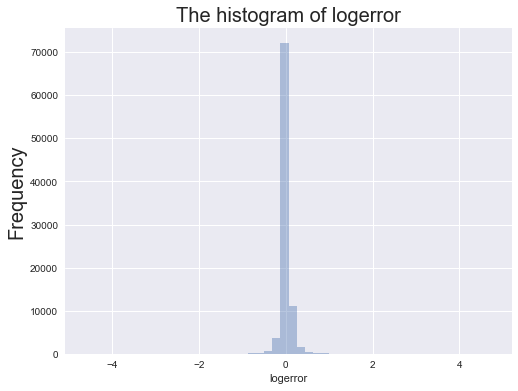

In [9]:
plt.figure(figsize=(8, 6))
ax = sns.distplot(y, kde = False)
ax.set_title("The histogram of logerror",fontsize = 20)
ax.set_ylabel("Frequency",fontsize = 20)

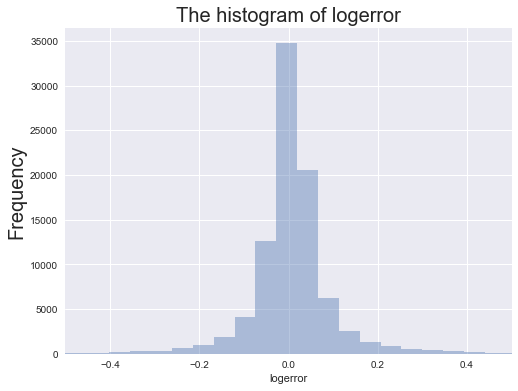

In [10]:
plt.figure(figsize=(8, 6))
ax = sns.distplot(y, kde = False, bins = 200)
ax.set(xlim = (-0.5, 0.5))
ax.set_title("The histogram of logerror",fontsize = 20)
ax.set_ylabel("Frequency",fontsize = 20)

### The distribution of logerror is near to normal distribution. No need to transform the response variable.

## Correlation between variables

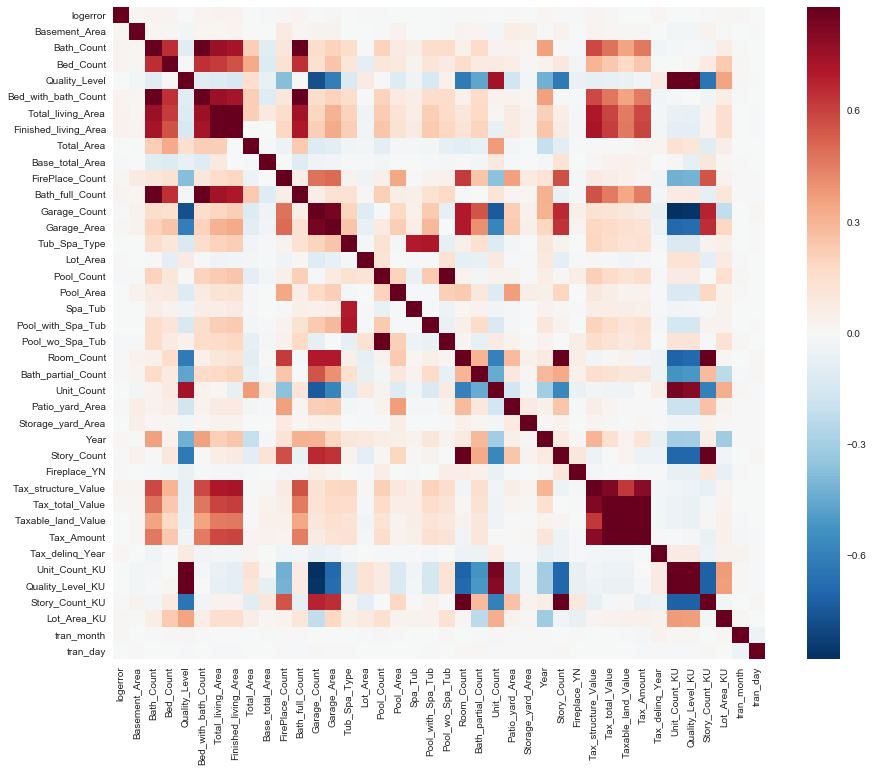

In [12]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

### logerror seems only have weak correlation with several numerical variables. Along the diagonal, we can observe several blocks with closely correlated variables, such as Bath_Count and Bed_Count, Bed_with_bath_Count, Total_living_Area and Finished_living_Area, etc. 

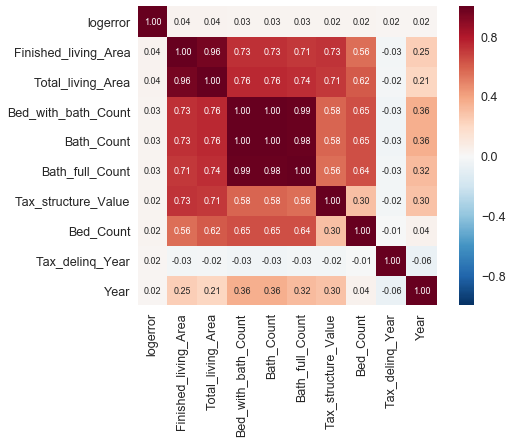

In [13]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'logerror')['logerror'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, annot_kws={'size': 9},square=True, fmt='.2f', 
                 yticklabels=cols.values, xticklabels=cols.values)